In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
from mmcls.models.builder import build_classifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import cm
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import build_dataset, build_dataloader, DATASETS
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import pandas
import json
import seaborn as sns
import seaborn.objects as so

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import visualize_cam_results
from scripts.utils.BlurDataset import get_blurred_dataset
from scripts.utils import preprocessing, io
from scripts.utils.model import get_wrongly_classified
from scripts.utils.evaluation import compare_original_blurred, get_eval_metrics
from scripts import evaluate_effectiveness
from scripts.generate_blurred import generate_blurred
from scripts import generate_statistics_seaborn

Importing BlurSegments step into Pipeline


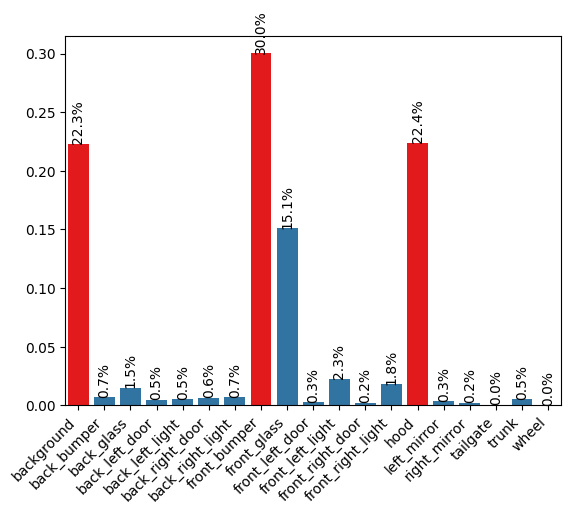

In [2]:
df = pandas.read_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx',
                       index_col=0)
ax = sns.barplot(data=df, x='segments', y='PercActivations', color = sns.color_palette("Paired")[1])
ax.set_xticklabels(df['segments'], rotation=45, ha="right")
ax.set(xlabel=None, ylabel=None)
print()
for i,b in enumerate(ax.patches):
    ax.text(b.get_x()+b.get_width()/2.0, b.get_height(), f'{b.get_height():.1%}', 
            ha='center', va='bottom', rotation=90)
    if i == 0 or i == 7 or i == 13:
        b.set_facecolor(sns.color_palette("Paired")[5])

In [38]:
df = pandas.read_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx',
                      index_col=0)
df2 = pandas.read_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/SwinBase/Data_Full_EigenCAM_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx',
                      index_col=0)

Output path is not a directory. Using base directory: ..
Saving images to: ./modelComparison.pdf


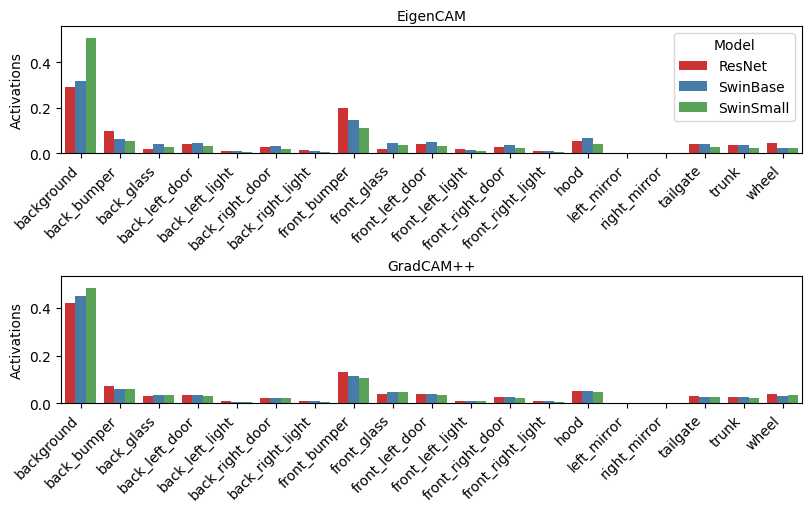

In [44]:
template='C:/Users/Linus/Desktop/copy/results/{dataset}/{Model}/Data_Full_{CAM}_{Model}_{dataset}_ocrnet_hr48_carparts_noflip_{date}.xlsx'

resEigen = template.format(Model='ResNet', dataset='CompCars_Web', date='23_08_2022', CAM='EigenCAM')
swinBaseEigen = template.format(Model='SwinBase', dataset='CompCars_Web', date='23_08_2022', CAM='EigenCAM')
swinSmallEigen = template.format(Model='SwinSmall', dataset='CompCars_Web', date='23_08_2022', CAM='EigenCAM')

resgradpp = template.format(Model='ResNet', dataset='CompCars_Web', date='23_08_2022', CAM='gradCAM++')
swinBasegradpp = template.format(Model='SwinBase', dataset='CompCars_Web', date='23_08_2022', CAM='gradCAM++')
swinSmallgradpp = template.format(Model='SwinSmall', dataset='CompCars_Web', date='23_08_2022', CAM='gradCAM++')

generate_statistics.generate_model_comparison([resEigen, swinBaseEigen, swinSmallEigen],
                                              [resgradpp, swinBasegradpp, swinSmallgradpp], 
                                              n_plots=2, save=True, title=['EigenCAM', 'GradCAM++'])


Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


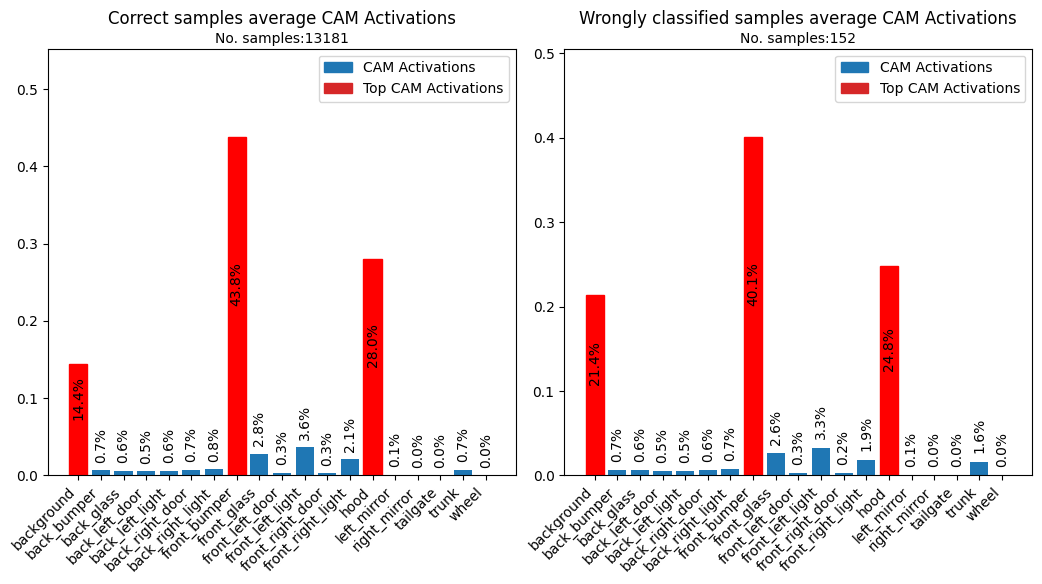

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\ResOGEigen.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_ResOGEigen.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


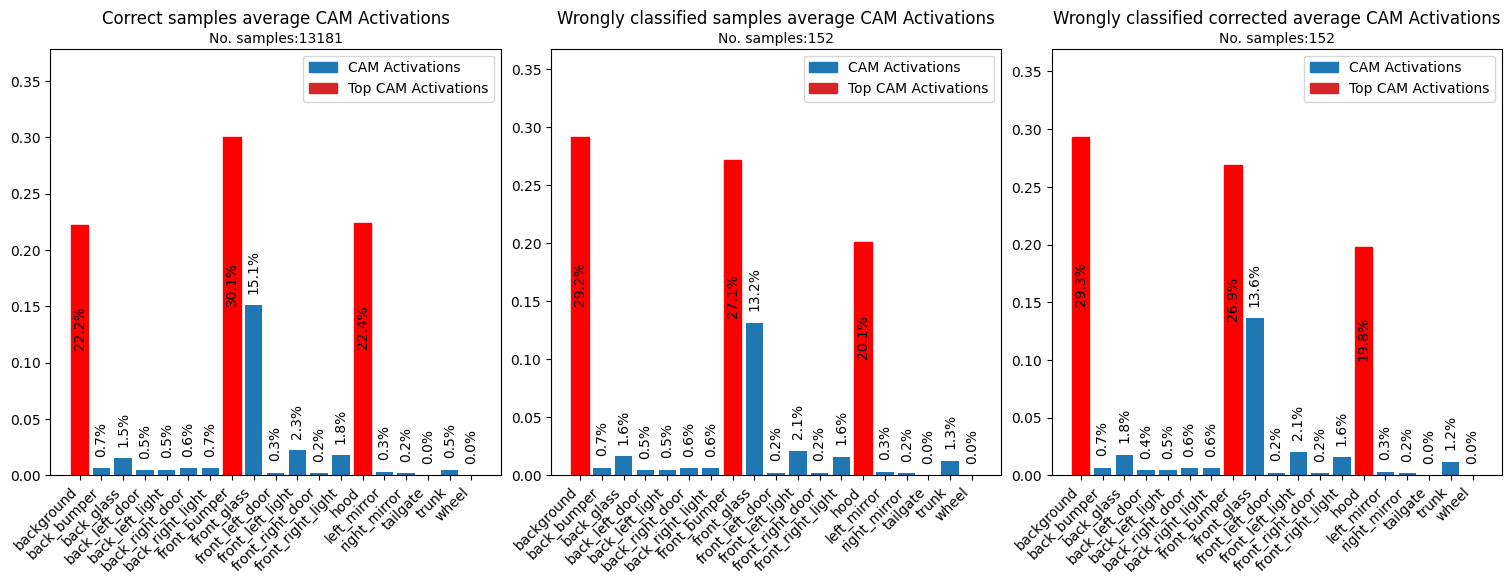

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\ResOGGrad.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_ResOGGrad.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


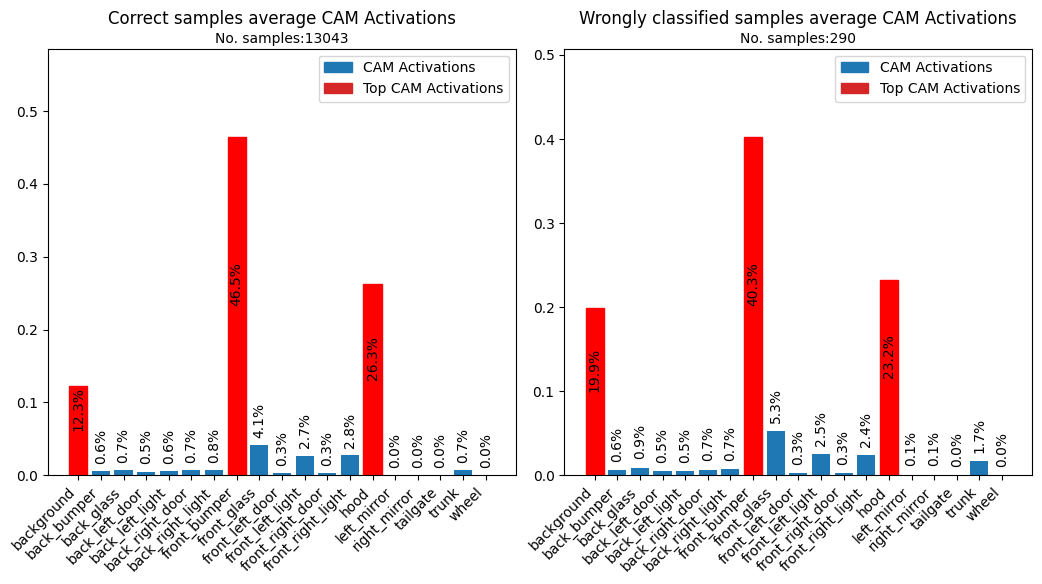

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\BaseOGEigen.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_BaseOGEigen.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


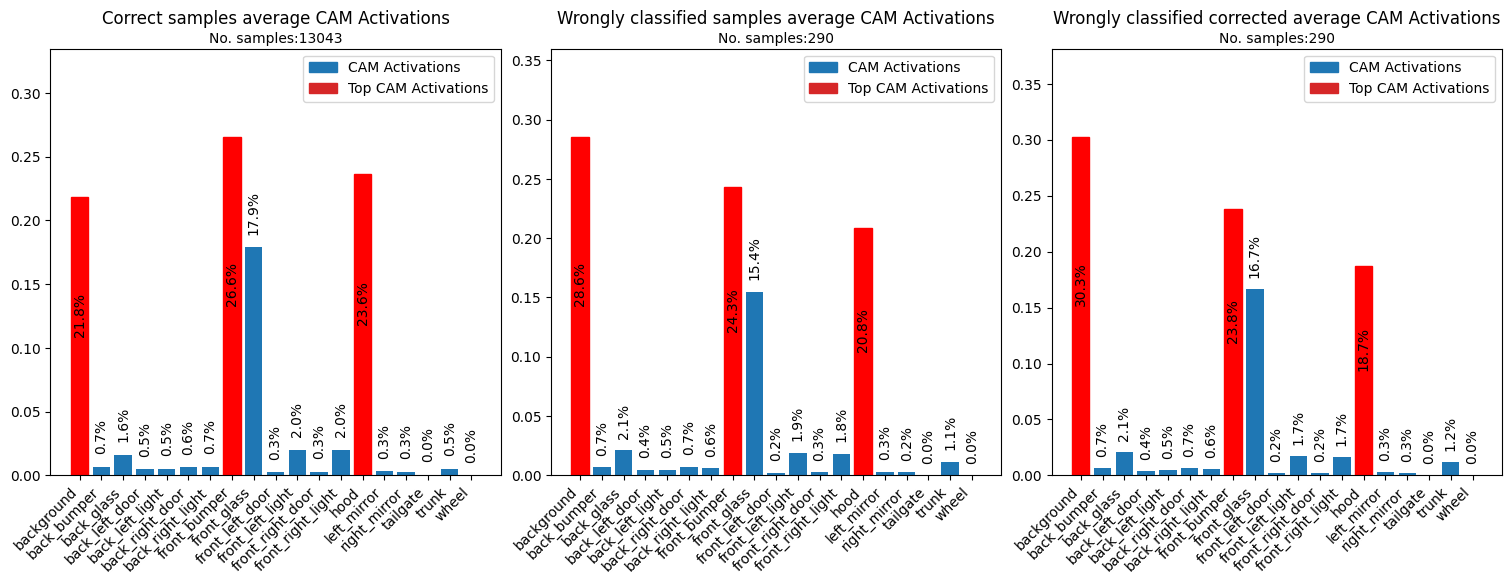

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\BaseOGGrad.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_BaseOGGrad.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


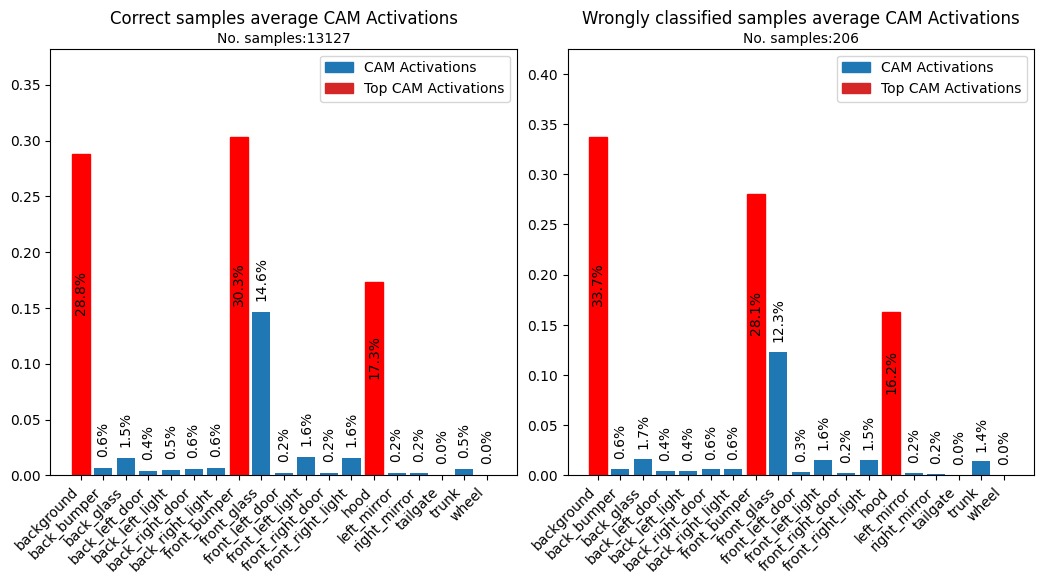

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\SmallOGEigen.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_SmallOGEigen.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


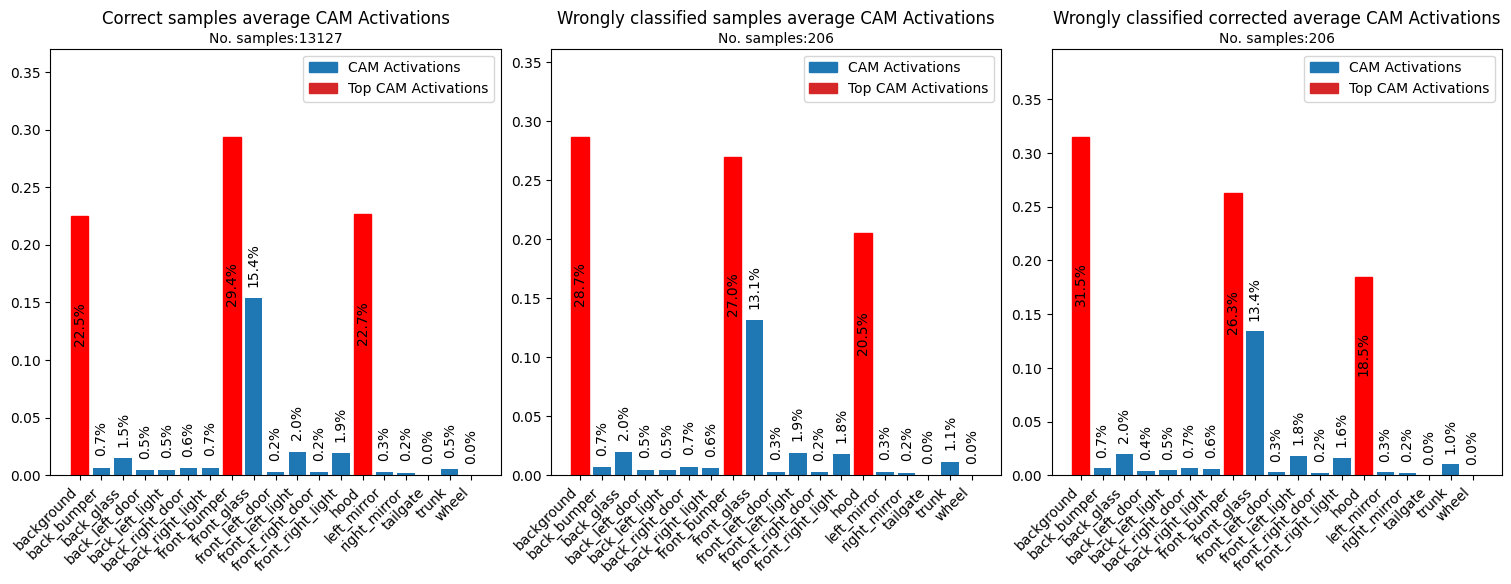

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\SmallOGGrad.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_SmallOGGrad.xlsx


In [19]:
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='ResOGEigen', plotFinalCompare=False, plotCorrected=False,
                                                      numSamples=13333, num_samples_correct=13181, num_samples_incorrect=152)
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='ResOGGrad', plotFinalCompare=False,
                                                      numSamples=13333, num_samples_correct=13181, num_samples_incorrect=152)


generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='BaseOGEigen', plotFinalCompare=False,plotCorrected=False,
                                                      numSamples=13333, num_samples_correct=13043, num_samples_incorrect=290)
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='BaseOGGrad', plotFinalCompare=False,
                                                      numSamples=13333, num_samples_correct=13043, num_samples_incorrect=290)

generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='SmallOGEigen', plotFinalCompare=False,plotCorrected=False,
                                                      numSamples=13333, num_samples_correct=13127, num_samples_incorrect=206)
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='SmallOGGrad', plotFinalCompare=False,
                                                      numSamples=13333, num_samples_correct=13127, num_samples_incorrect=206)

Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Color\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


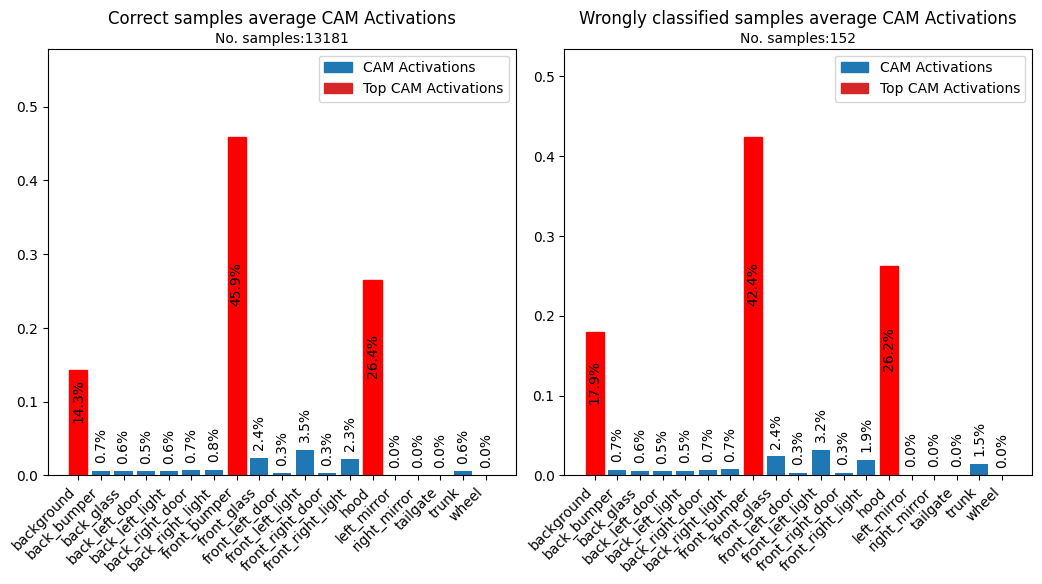

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\ResColorEigen.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_ResColorEigen.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Color\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


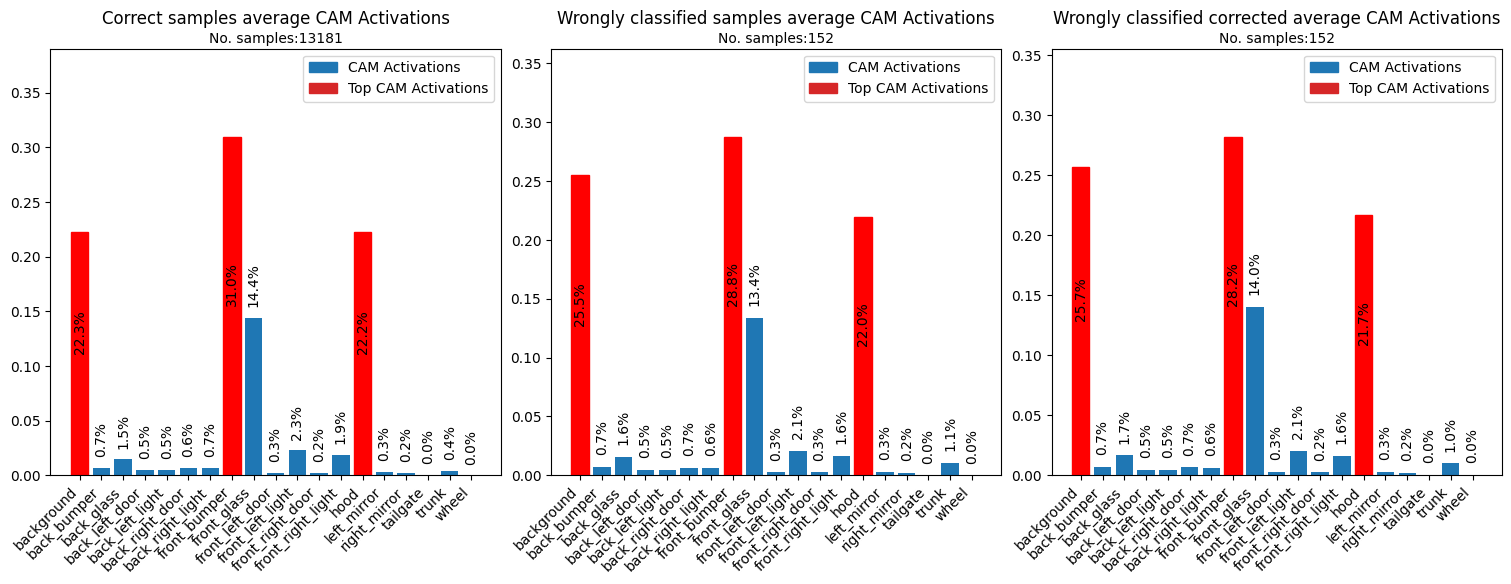

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\ResColorGrad.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_ResColorGrad.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


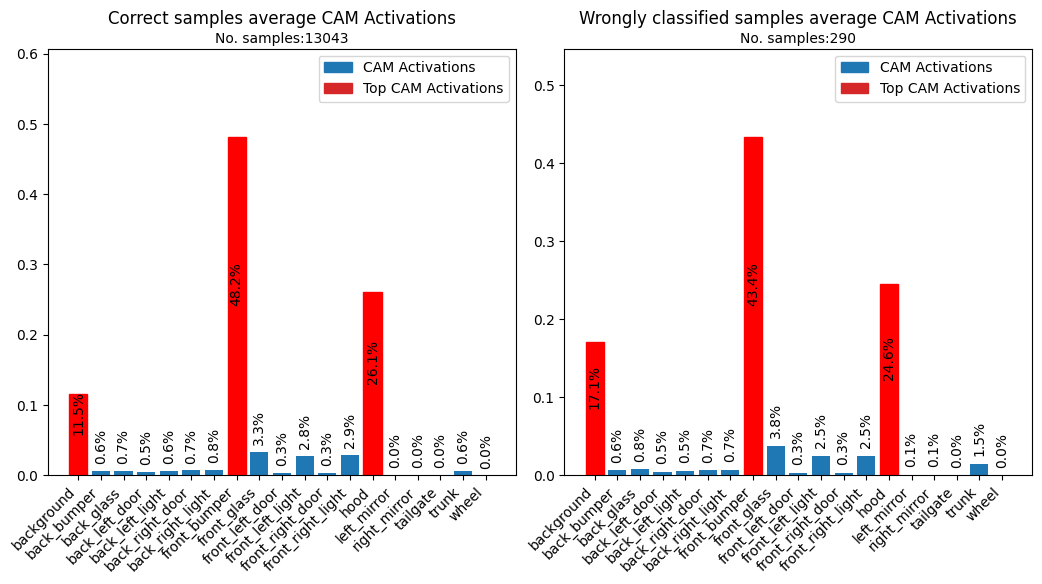

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\BaseColorEigen.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_BaseColorEigen.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


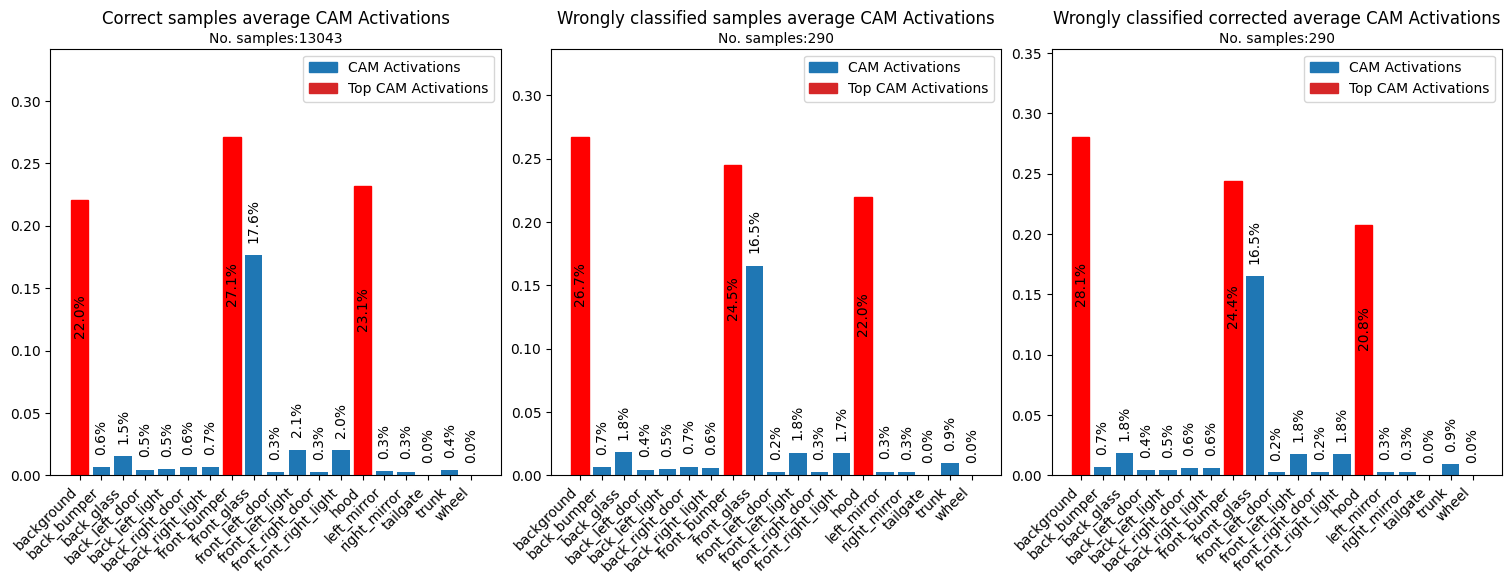

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\BaseColorGrad.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_BaseColorGrad.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


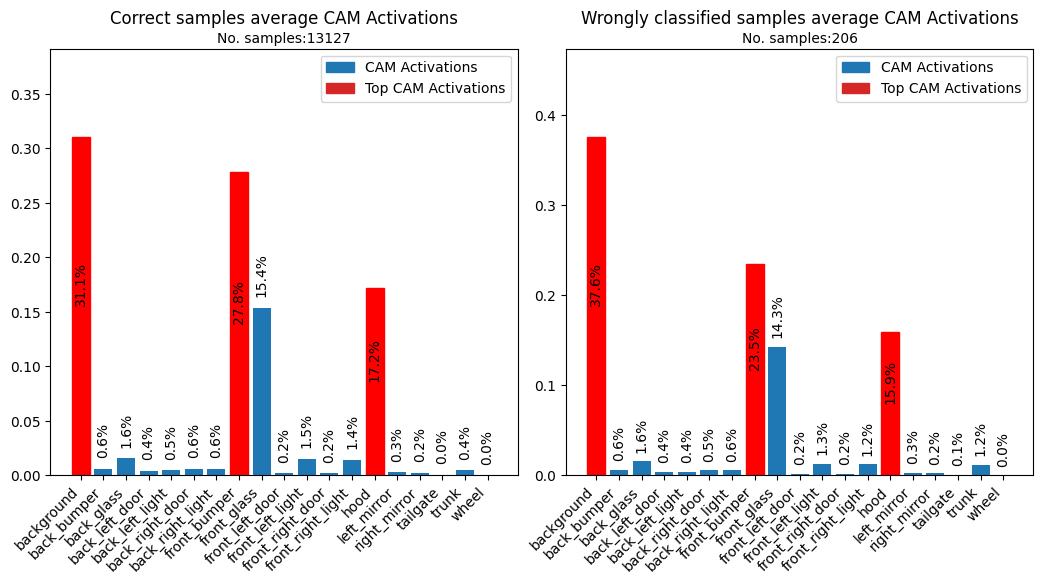

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\SmallColorEigen.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_SmallColorEigen.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


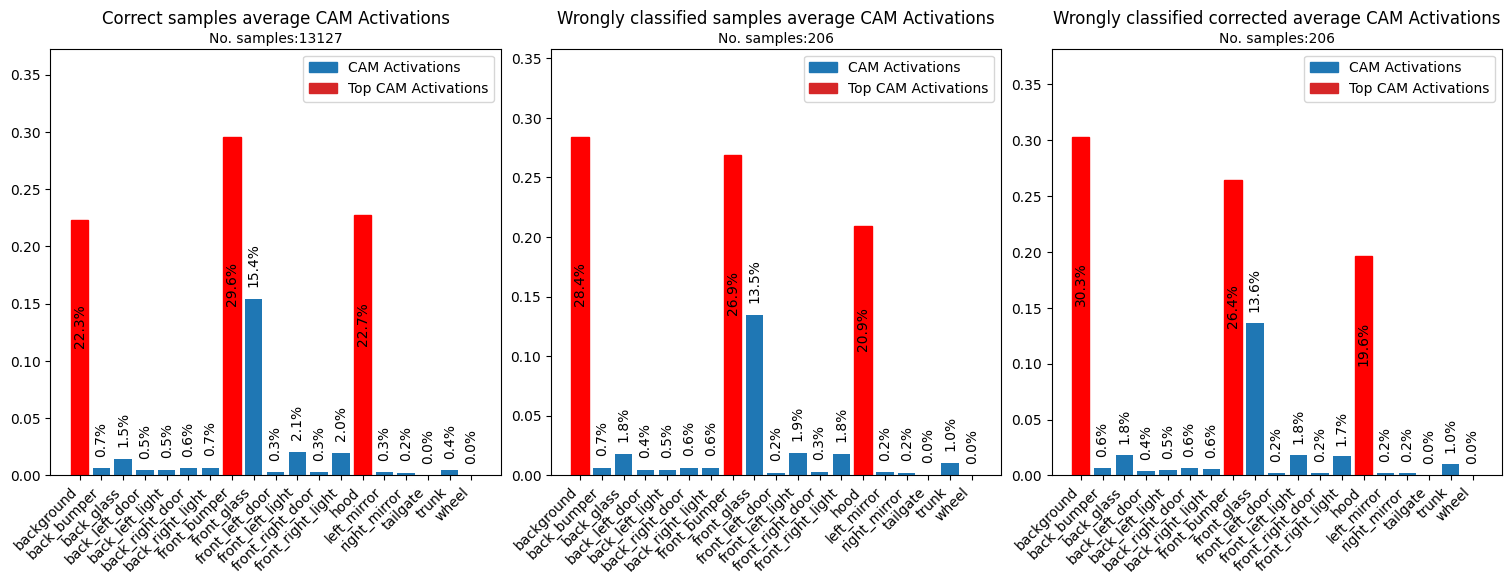

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\SmallColorGrad.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_SmallColorGrad.xlsx


In [12]:
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='ResColorEigen', plotFinalCompare=False,plotCorrected=False,
                                                      numSamples=13333, num_samples_correct=13181, num_samples_incorrect=152)
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='ResColorGrad', plotFinalCompare=False,
                                                      numSamples=13333, num_samples_correct=13181, num_samples_incorrect=152)


generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='BaseColorEigen', plotFinalCompare=False,plotCorrected=False,
                                                      numSamples=13333, num_samples_correct=13043, num_samples_incorrect=290)
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='BaseColorGrad', plotFinalCompare=False,
                                                      numSamples=13333, num_samples_correct=13043, num_samples_incorrect=290)

generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='SmallColorEigen', plotFinalCompare=False,plotCorrected=False,
                                                      numSamples=13333, num_samples_correct=13127, num_samples_incorrect=206)
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='SmallColorGrad', plotFinalCompare=False,
                                                      numSamples=13333, num_samples_correct=13127, num_samples_incorrect=206)

Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


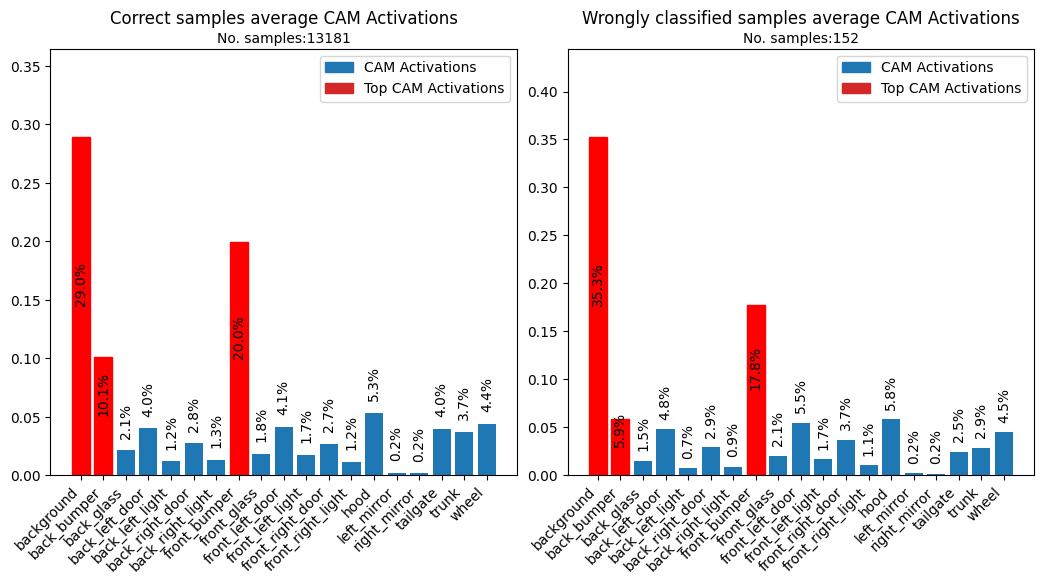

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\ResWebEigen.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_ResWebEigen.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


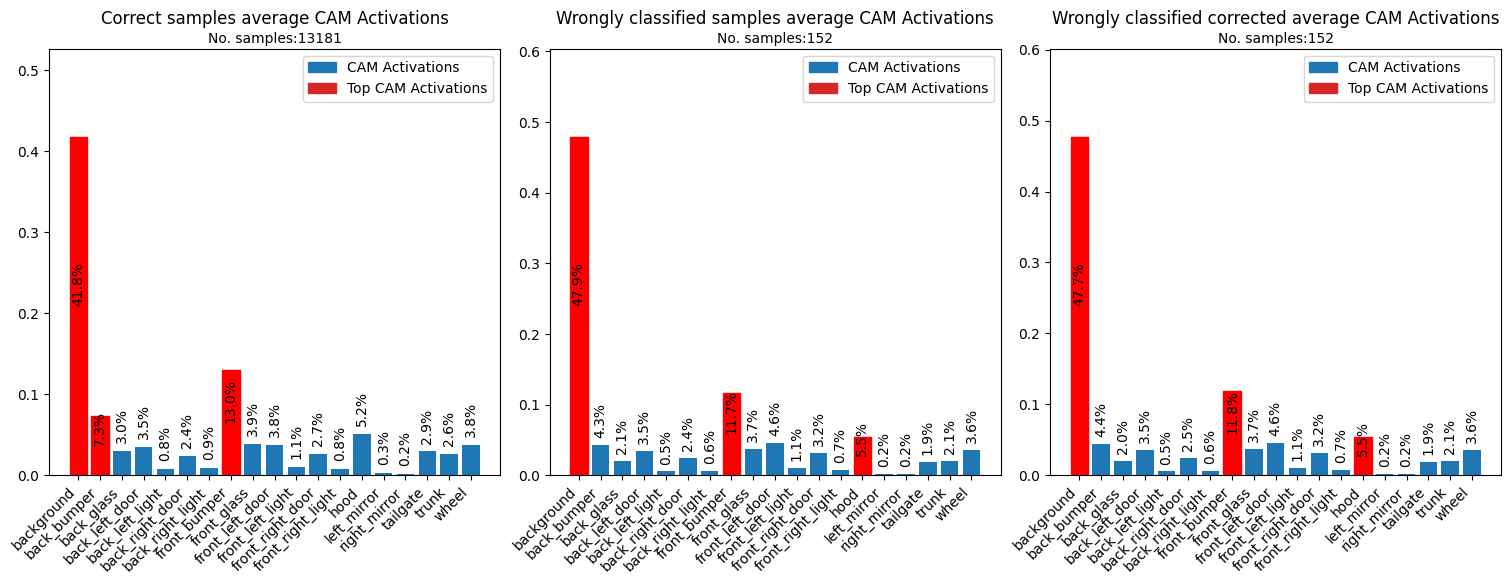

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\ResWebGrad.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_ResWebGrad.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


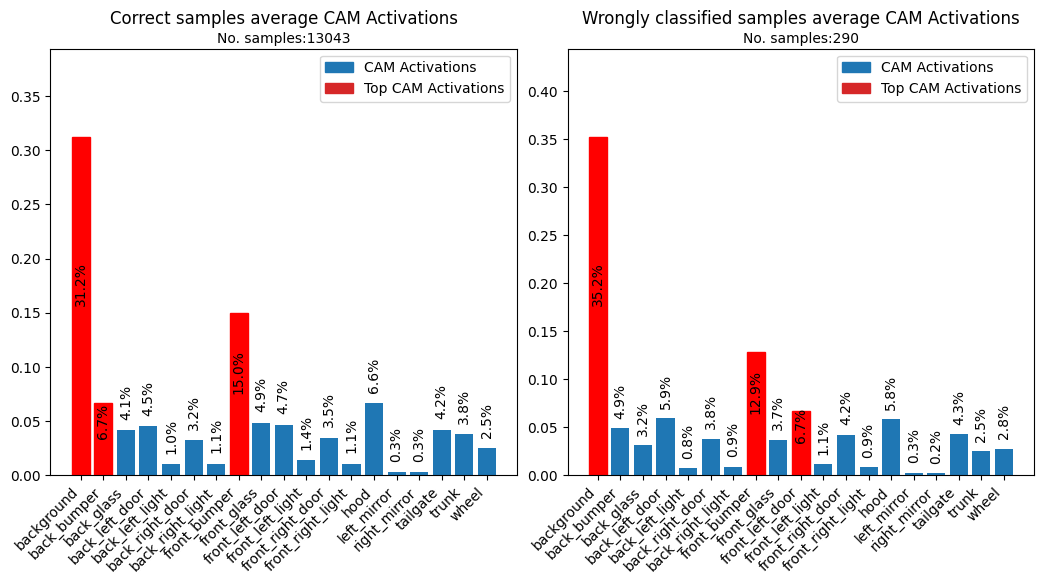

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\BaseWebEigen.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_BaseWebEigen.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


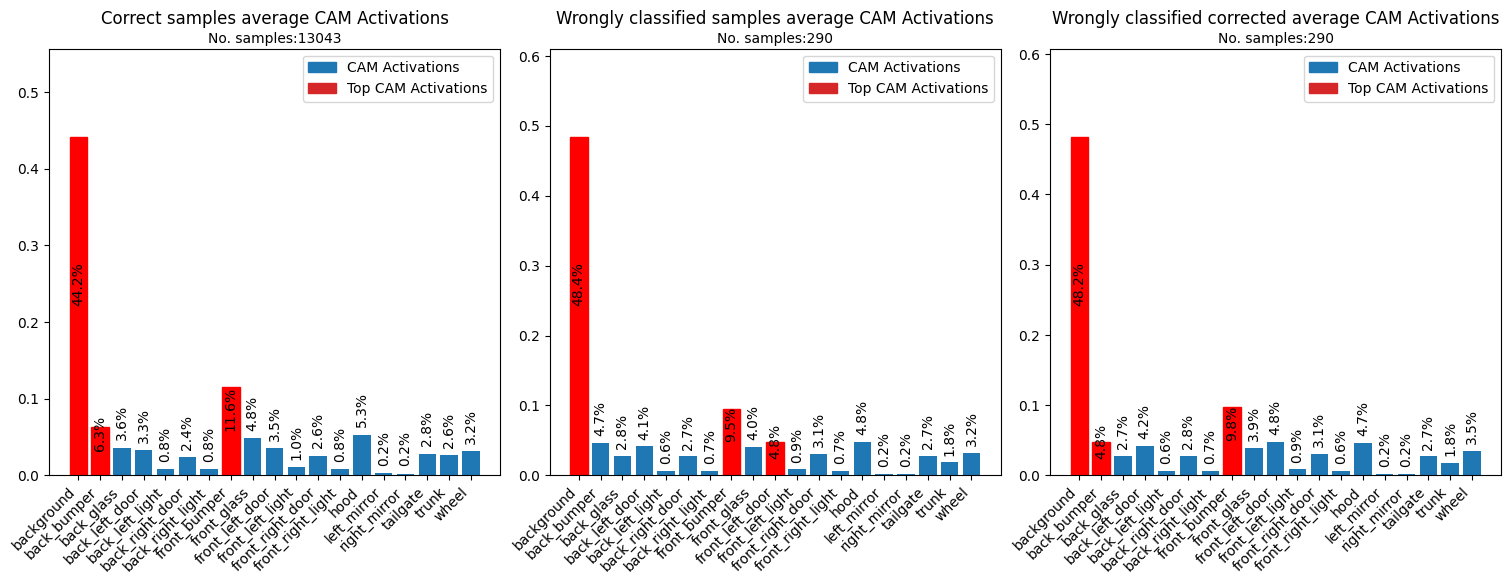

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\BaseWebGrad.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_BaseWebGrad.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


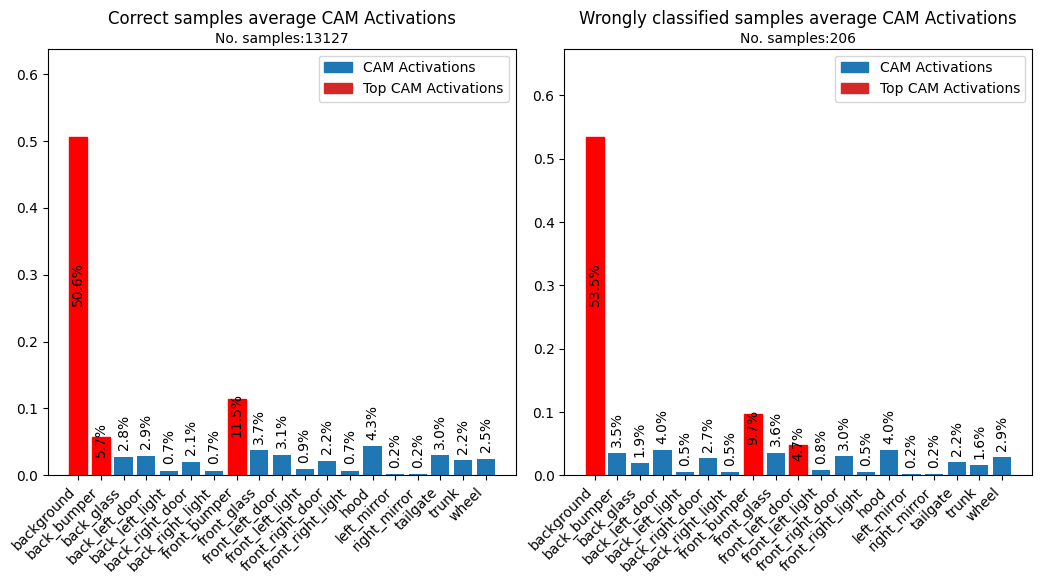

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\SmallWebEigen.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_SmallWebEigen.xlsx
Using given results from file C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx


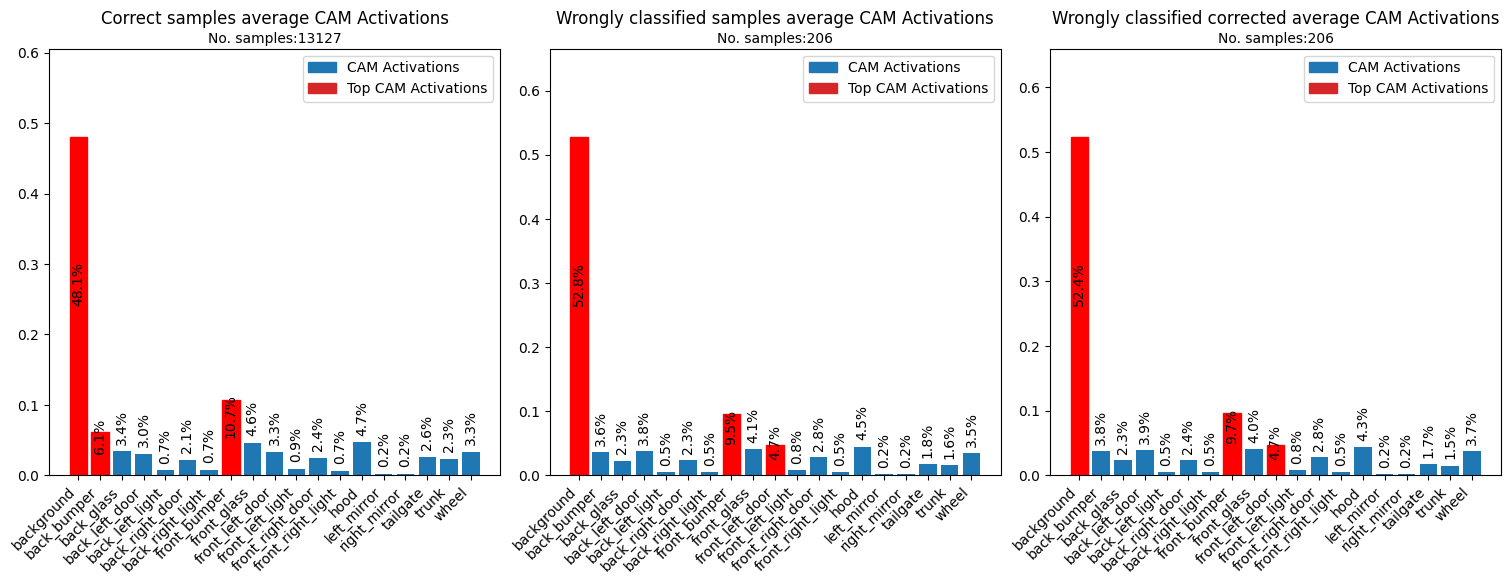

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\SmallWebGrad.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_SmallWebGrad.xlsx


In [13]:
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='ResWebEigen', plotFinalCompare=False,plotCorrected=False,
                                                      numSamples=13333, num_samples_correct=13181, num_samples_incorrect=152)
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='ResWebGrad', plotFinalCompare=False,
                                                      numSamples=13333, num_samples_correct=13181, num_samples_incorrect=152)


generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='BaseWebEigen', plotFinalCompare=False,plotCorrected=False,
                                                      numSamples=13333, num_samples_correct=13043, num_samples_incorrect=290)
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='BaseWebGrad', plotFinalCompare=False,
                                                      numSamples=13333, num_samples_correct=13043, num_samples_incorrect=290)

generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='SmallWebEigen', plotFinalCompare=False,plotCorrected=False,
                                                      numSamples=13333, num_samples_correct=13127, num_samples_incorrect=206)
generate_statistics.generate_statistics_missclassified(results_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      saveFigureFormat='.pdf', filename='SmallWebGrad', plotFinalCompare=False,
                                                      numSamples=13333, num_samples_correct=13127, num_samples_incorrect=206)

Output path is not a directory. Using base directory: ..
Saving images to: ./wronglyClassified.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./wronglyClassified.pdf


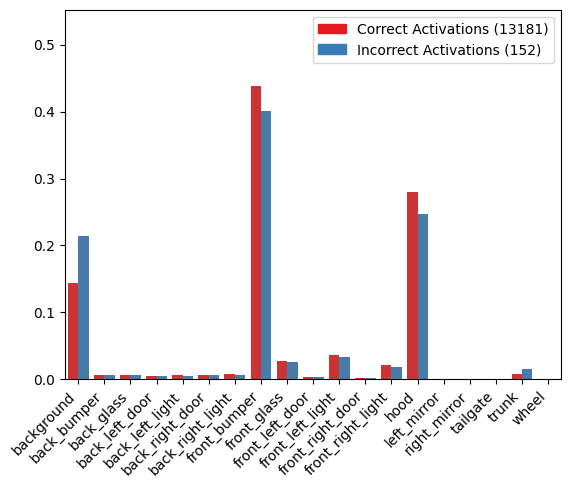

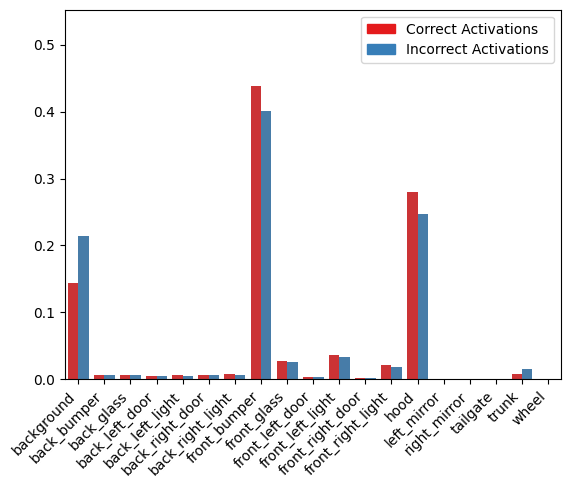

In [50]:
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                                    include_corrected=False,show_perc=False, n_samples=[13181,152])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                                    include_corrected=False,show_perc=False)

Output path is not a directory. Using base directory: ..
Saving images to: ./ResOGEigen.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./ResOGEigenNum.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./ResOGGrad.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./ResOGGradNum.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./BaseOGEigen.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./BaseOGEigenNum.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./BaseOGGrad.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./BaseOGGradNum.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./SmallOGEigen.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./SmallOGEigenNum.pdf
Output path is not a directory. Using base directory: ..
Savi

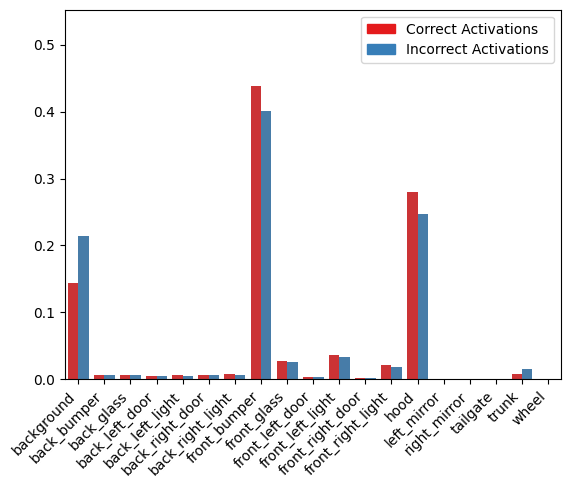

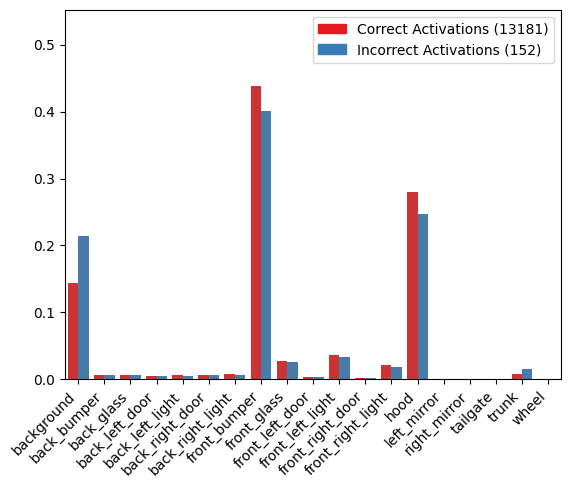

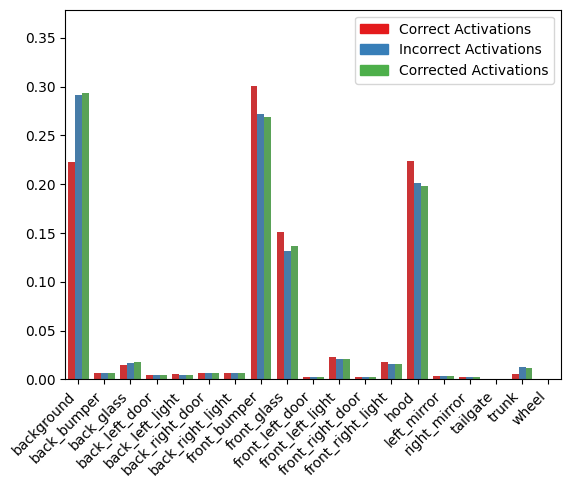

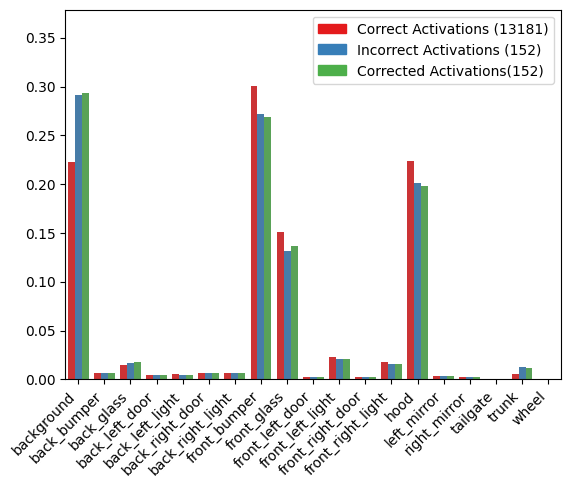

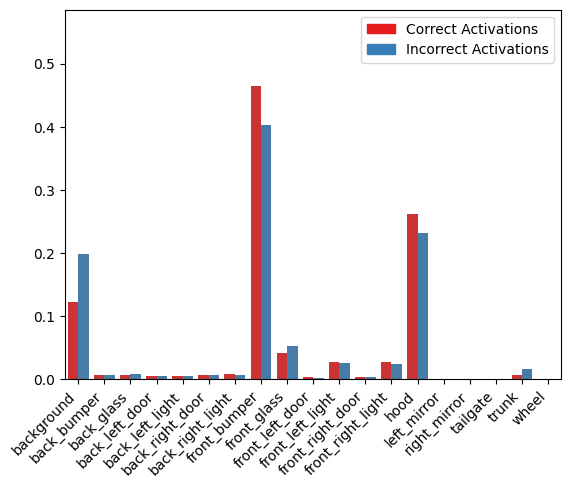

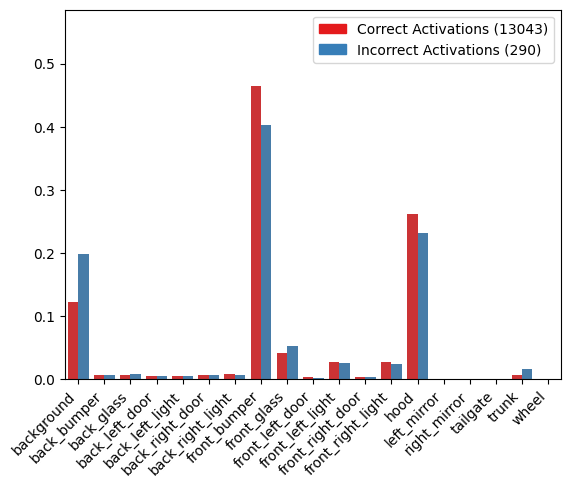

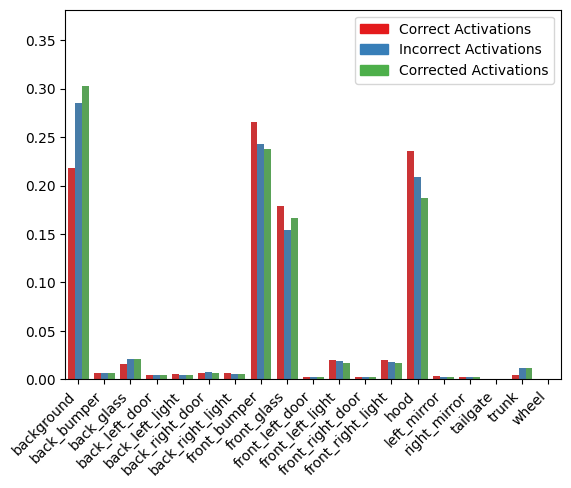

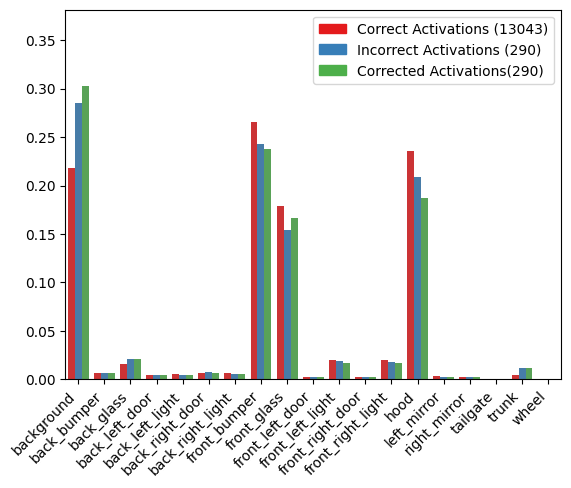

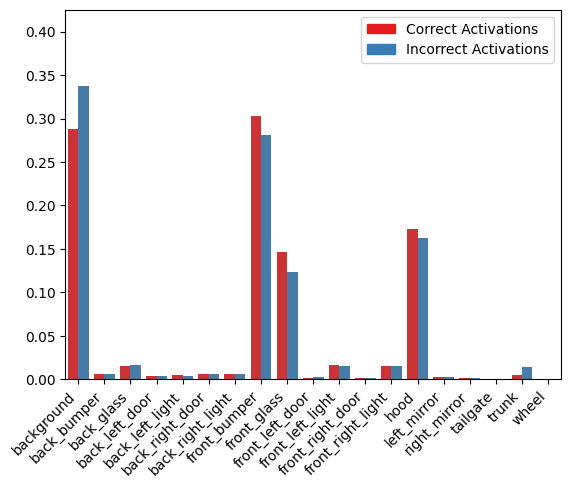

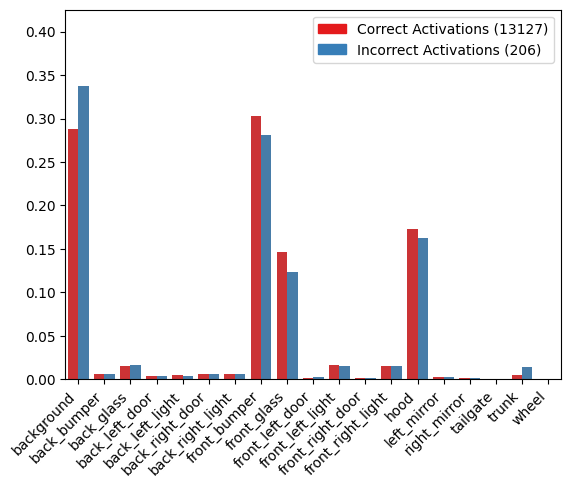

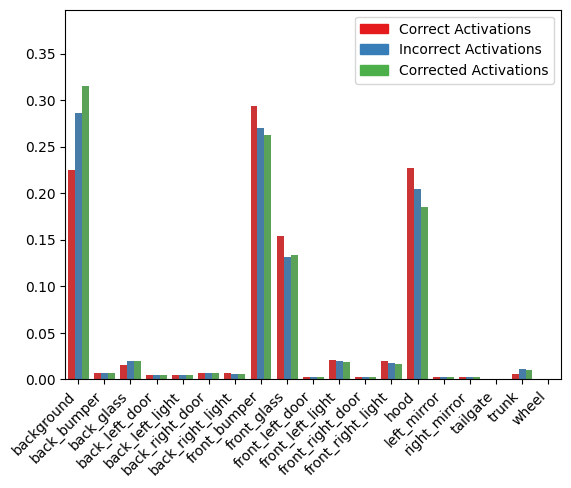

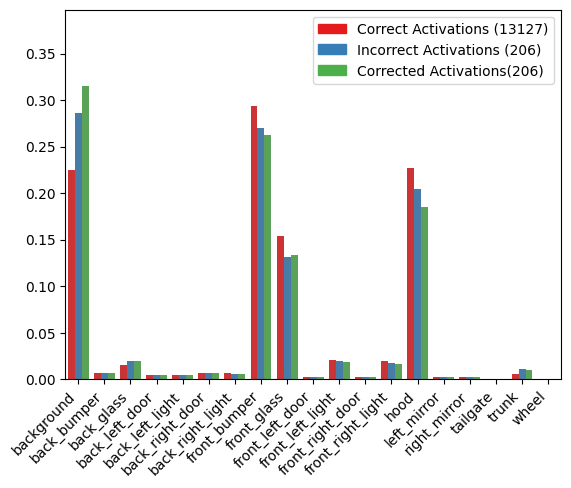

In [55]:
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='ResOGEigen')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='ResOGEigenNum', n_samples=[13181,152])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='ResOGGrad')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='ResOGGradNum', n_samples=[13181,152])


generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='BaseOGEigen')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='BaseOGEigenNum', n_samples=[13043,290])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='BaseOGGrad')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='BaseOGGradNum', n_samples=[13043,290])


generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='SmallOGEigen')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='SmallOGEigenNum', n_samples=[13127,206])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='SmallOGGrad')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='SmallOGGrad', n_samples=[13127,206])

In [ ]:
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='ResColorEigen')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='ResColorEigenNum', n_samples=[12424,955])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='ResColorGrad')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='ResColorGradNum', n_samples=[12424,955])


generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='BaseColorEigen')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='BaseColorEigenNum', n_samples=[11762,1617])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='BaseColorGrad')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='BaseColorGradNum', n_samples=[11762,1617])


generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='SmallColorEigen')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='SmallColorEigenNum', n_samples=[12468,911])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='SmallColorGrad')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Color\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Color_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='SmallColorGrad', n_samples=[12468,911])

In [ ]:
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='ResWebEigen')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='ResWebEigenNum', n_samples=[15078,549])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='ResWebGrad')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\wronglyClassifications\Data_Full_gradCAM++_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='ResWebGradNum', n_samples=[15078,549])


generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='BaseWebEigen')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\wronglyClassifications\Data_Full_EigenCAM_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='BaseWebEigenNum', n_samples=[11762,1617])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='BaseWebGrad')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\wronglyClassifications\Data_Full_gradCAM++_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='BaseWebGradNum', n_samples=[11762,1617])


generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='SmallWebEigen')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\wronglyClassifications\Data_Full_EigenCAM_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=False,show_perc=False, 
                                                    file_name='SmallWebEigenNum', n_samples=[12468,911])
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='SmallWebGrad')
generate_statistics_seaborn.generate_wrongly_classified_consolidated(result_file=r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\wronglyClassifications\Data_Full_gradCAM++_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_wrongClassified_22_08_2022.xlsx',
                                                      include_corrected=True,show_perc=False, 
                                                    file_name='SmallWebGrad', n_samples=[12468,911])